## Załadowanie bibliotek





In [ ]:
import numpy as np
import pandas as pd

from pyspark.sql import functions as f
from pyspark.sql.types import IntegerType
from pyspark.sql import SparkSession, Row
from pyspark.sql.window import Window

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import plotly.express as px 
import plotly.graph_objects as go
import seaborn as sns

from itertools import chain
import warnings
warnings.filterwarnings('ignore')

## Uruchomienie aplikacji

In [ ]:
spark = SparkSession.builder.appName("Football").master("local[*]").getOrCreate()

# **Przygotowanie DataFrame'ów**

In [ ]:
# build matches dataframe and unpivot teamId
path_to_bucket = ''
matchesJson = spark.read.json(path=path_to_bucket+"data/matches/*.json", multiLine=True)

m = matchesJson.select("competitionId","wyId","teamsData.*","label","winner", "dateutc", "gameweek","roundId")

m.createOrReplaceTempView("matches")

l = []
separator = ','
A = matchesJson.select("teamsData.*").columns
B = separator.join(A).split(',')
n = len(A)

for a in range(len(A)):
    l.append("'{}'".format(A[a]) + ",`" + B[a] + "`")

k = separator.join(l)

matches = spark.sql("select competitionId, wyId, label, winner, winner, dateutc, gameweek, roundId, stack(%d,%s) as (team, info) from matches" % (n,k)).where("info is not null")

spark.catalog.dropTempView("matches")

# build players dataframe
players = spark.read.json(path=path_to_bucket+"data/players.json")

#build teams dataframe
teams = spark.read.json(path=path_to_bucket+"data/teams.json")

# build events dataframe
events = spark.read.json(path=path_to_bucket+"data/events/*.json", multiLine=True)


# **Informacje o zbiorze danych**
Zbiory danych wykorzystane w analizie zostały zebrane przez Wyscout. Firma Wyscout zbiera dane wykorzystując operatorów, którzy na podstawie filmów z meczów piłkarskich określają zdarzenie oraz względną pozycję zawodnika. Cały zbiór danych WyScout dostarcza za pomocą REST API. Więcej szczegółów: https://apidocs.wyscout.com/

Analizowany zestaw danych jest udostępniony na licencji CC BY 4.0 i jest publicznie dostępna na figshare. Dane dotyczą sezonu 2017/2018 pięciu krajowych rozgrywek w Europie, pierwszych lig: hiszpańska, niemiecka, włoska, angielska, francuska.

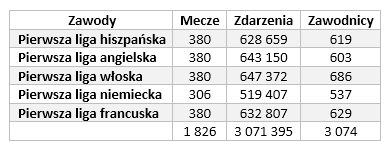



## Schematy

In [ ]:
players.printSchema()

root
 |-- birthArea: struct (nullable = true)
 |    |-- alpha2code: string (nullable = true)
 |    |-- alpha3code: string (nullable = true)
 |    |-- id: string (nullable = true)
 |    |-- name: string (nullable = true)
 |-- birthDate: string (nullable = true)
 |-- currentNationalTeamId: string (nullable = true)
 |-- currentTeamId: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- foot: string (nullable = true)
 |-- height: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- middleName: string (nullable = true)
 |-- passportArea: struct (nullable = true)
 |    |-- alpha2code: string (nullable = true)
 |    |-- alpha3code: string (nullable = true)
 |    |-- id: string (nullable = true)
 |    |-- name: string (nullable = true)
 |-- role: struct (nullable = true)
 |    |-- code2: string (nullable = true)
 |    |-- code3: string (nullable = true)
 |    |-- name: string (nullable = true)
 |-- shortName: string (nullable = true)
 |-- weight: long (nullabl

In [ ]:
teams.printSchema()

root
 |-- area: struct (nullable = true)
 |    |-- alpha2code: string (nullable = true)
 |    |-- alpha3code: string (nullable = true)
 |    |-- id: string (nullable = true)
 |    |-- name: string (nullable = true)
 |-- city: string (nullable = true)
 |-- name: string (nullable = true)
 |-- officialName: string (nullable = true)
 |-- type: string (nullable = true)
 |-- wyId: long (nullable = true)



In [ ]:
matches.printSchema()

root
 |-- competitionId: long (nullable = true)
 |-- wyId: long (nullable = true)
 |-- label: string (nullable = true)
 |-- winner: long (nullable = true)
 |-- winner: long (nullable = true)
 |-- dateutc: string (nullable = true)
 |-- gameweek: long (nullable = true)
 |-- roundId: long (nullable = true)
 |-- team: string (nullable = true)
 |-- info: struct (nullable = true)
 |    |-- coachId: long (nullable = true)
 |    |-- formation: struct (nullable = true)
 |    |    |-- bench: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- goals: string (nullable = true)
 |    |    |    |    |-- ownGoals: string (nullable = true)
 |    |    |    |    |-- playerId: long (nullable = true)
 |    |    |    |    |-- redCards: string (nullable = true)
 |    |    |    |    |-- yellowCards: string (nullable = true)
 |    |    |-- lineup: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- goa

In [ ]:
events.printSchema()

root
 |-- eventId: long (nullable = true)
 |-- eventName: string (nullable = true)
 |-- eventSec: double (nullable = true)
 |-- id: long (nullable = true)
 |-- matchId: long (nullable = true)
 |-- matchPeriod: string (nullable = true)
 |-- playerId: long (nullable = true)
 |-- positions: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- x: long (nullable = true)
 |    |    |-- y: long (nullable = true)
 |-- subEventId: long (nullable = true)
 |-- subEventName: string (nullable = true)
 |-- tags: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: long (nullable = true)
 |-- teamId: long (nullable = true)



In [ ]:
df1 = events.select("eventName").groupBy("eventName").agg(f.count("eventName").alias("count")).orderBy("count", ascending=0)\
    .withColumn("percent",f.round(f.col('count')/f.sum('count').over(Window.partitionBy())*100,1))\
    .toPandas()
df1.set_index("eventName", inplace=True)

df2 = events.select("matchId").groupBy("matchId").count().toPandas()

Struktura zdarzeń w meczu - średnio

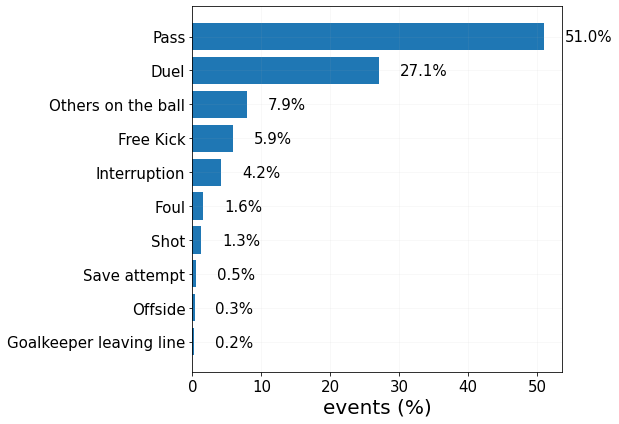

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
plt.barh(df1.index,df1.percent)
plt.gca().invert_yaxis()
plt.xticks(fontsize=15)
plt.xlabel('events (%)', fontsize=20)
plt.yticks(fontsize=15)
plt.grid(alpha=0.1)
fig.tight_layout()
for i, v in enumerate(df1.percent):
    plt.text(v + 3, i + 0.15 , str(v)+'%', color='black', fontsize=15)

plt.show()

Rozkład ilości zdarzeń w meczu

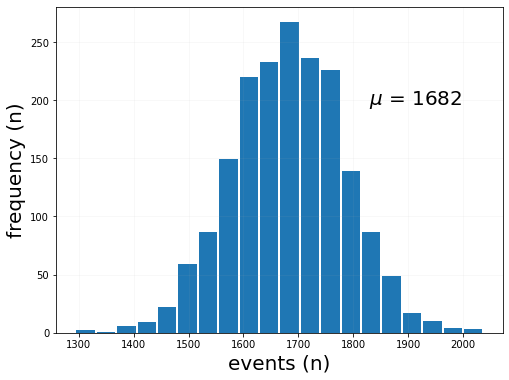

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
avgEvents = np.mean(df2["count"])
ax =  df2["count"].plot.hist(rwidth=0.9, bins=20)
plt.grid(alpha=0.1)
plt.xlabel('events (n)', fontsize=20)
plt.ylabel('frequency (n)', fontsize=20)
plt.text(0.7, 0.7, 
         '$\mu$ = %i' % (avgEvents), 
         fontsize=20, transform=ax.transAxes)
plt.show()

# **Podstawowe analizy**

Pytania:
1. W jakich minutach meczu najcześciej zdobywane są bramki, żółte i czerwone kartki? 
2. W jakim procencie miejsce rozgrywania meczu wpływa na końcowy rezultat?
3. Statystyka goli, rzutów karnych: strzelone, niestrzelone, obronione, nietrafione. W którym obszarze w bramce jest najwięcej trafień z rzutów karnych.
4. Ile goli strzelają zawodnicy wchodzący z ławki rezerwowych w stosunku do tych, którzy grają od początki? Czy opłaca się dokonywać zmian (kryterium goli dla napastników)?
5. Analiza taktyki konkretnego zespołu.
6. W jaki stopniu można przewidzieć wynik meczu na podstawie tych zbiorów danych?

## 1. Gole, żółte i czerwone kartki

In [ ]:
goalYellowRedCards = events\
  .select("eventName","matchPeriod","eventSec",f.explode("tags.id").alias("tagId"))

goalYellowRedCards = goalYellowRedCards\
  .filter(f.col("tagId").isin([101,1701,1702]))\
  .filter(f.col("eventName") != "Save attempt")\
  .filter(f.col("matchPeriod").isin(["1H","2H"]))\
  .select("eventSec","matchPeriod","tagId")

goalYellowRedCards = goalYellowRedCards\
    .withColumn("eventMin",f.floor(f.col("eventSec")/60))\
    .withColumn("matchTime",f.floor(f.col("eventMin")/5))\
    .withColumn("matchTime",f.when(f.col("matchTime")>9,9).otherwise(f.col("matchTime")))\
    .withColumn("matchTime",f.when(f.col("matchPeriod") == "2H", f.col("matchTime") + 11).otherwise(f.col("matchTime")))
    
goalYellowRedCards = goalYellowRedCards\
    .groupBy("matchPeriod","matchTime")\
    .pivot("tagId")\
    .count()\
    .orderBy("matchPeriod","matchTime")\
    .fillna(0)\
    .withColumnRenamed("101","goal")\
    .withColumnRenamed("1701","redCard")\
    .withColumnRenamed("1702","yellowCard")

# goalYellowRedCards.show()
pdgoalYellowRedCards = goalYellowRedCards.toPandas()
pdgoalYellowRedCards
xlabels = ['0-4','5-9','10-14','15-19','20-24','25-29','30-34','35-39','40-44','>=45','45-49','50-54','55-59','60-64','65-69','70-74','75-79','80-84','85-89','>=90']

In [ ]:
fig = px.bar(pdgoalYellowRedCards,y="goal", x="matchTime", color = "matchPeriod", labels={"goal": "goals","matchTime":"match time"}, text="goal", )
fig.update_layout(xaxis=dict( tickmode = 'array',
        tickvals = pdgoalYellowRedCards["matchTime"],
        ticktext = xlabels))
fig.show()

fig = px.bar(pdgoalYellowRedCards,y="yellowCard", x="matchTime", color = "matchPeriod", labels={"yellowCard": "yellow cards","matchTime":"match time"}, text="yellowCard", )
fig.update_layout(xaxis=dict( tickmode = 'array',
        tickvals = pdgoalYellowRedCards["matchTime"],
        ticktext = xlabels))
fig.show()

fig = px.bar(pdgoalYellowRedCards,y="redCard", x="matchTime", color = "matchPeriod", labels={"redCard": "red cards","matchTime":"match time"}, text="redCard", )
fig.update_layout(xaxis=dict( tickmode = 'array',
        tickvals = pdgoalYellowRedCards["matchTime"],
        ticktext = xlabels))
fig.show()


## 2. Miejsce rozgrywania, struktura wyników

In [ ]:
pdHomeResults = matches.select("wyId","winner","team","info.side").filter((f.col("winner") == f.col("team")) | (f.col("winner") == 0))\
    .withColumn("home",f.when(f.col("winner") == 0, "draw").when(f.col("side") == "home", "win").otherwise("loss"))\
    .select("wyId","home")\
    .distinct()\
    .groupBy("home")\
    .agg(f.count("home").alias("count"))\
    .toPandas()

pdHomeResults

,home,count
0,win,822
1,loss,550
2,draw,454


In [ ]:
fig = px.pie(pdHomeResults, names="home", values="count", hole=0.3)
fig.update_layout(title="Rezultaty uzyskiwane przez drużyny grające na własnym boisku", title_x=0.5)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

## 3. Statystyka goli, rzutów karnych

In [ ]:
actionType = events\
    .filter(f.col("eventName") != "Save attempt")\
    .select("eventName", "subEventName", f.col("tags.id").alias("tagId"))\
    .filter(f.array_contains("tagId",101))\
    .groupBy("subEventName")\
    .agg(f.count("tagId").alias("goals"))\
    .orderBy("goals", ascending=0)
    # .show(truncate=False)

# actionType.show()
goals = actionType.toPandas().set_index(["subEventName"])
goals

,goals
subEventName,
Shot,4271
Penalty,393
Free kick shot,126
Corner,3


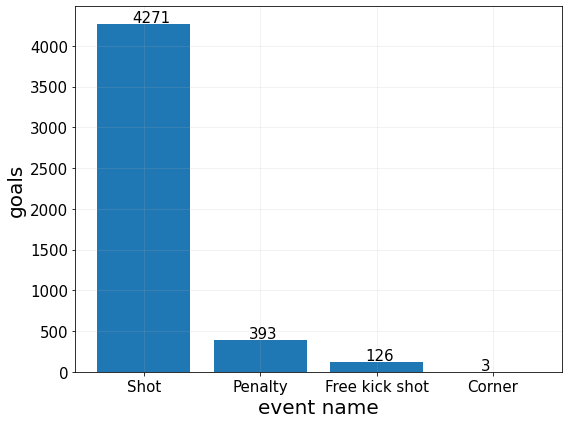

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
# ax = b.plot.bar(stacked=True)
plt.bar(x=goals.index, height=goals.goals)
plt.xticks(fontsize=15)
plt.xlabel('event name', fontsize=20)
plt.yticks(fontsize=15)
plt.ylabel('goals', fontsize=20)
plt.grid(alpha=0.2)
fig.tight_layout()
for i, v in enumerate(goals.goals):
    ax.text(i - 0.10, v + 20, str(v), color='black', fontsize=15)
plt.show()


In [ ]:
positionGoal = [1201,1202,1203,1204,1205,1206,1207,1208,1209]
positionOut = [i for i in range(1201,1224) if i not in positionGoal]

penalty = events\
    .filter(((f.array_contains(f.expr("tags.id"), 101)) | (f.col("subEventName") == 'Penalty')) & (f.col("eventName") != "Save attempt" ))\
    .select("eventName", "subEventName",f.col("tags.id").alias("id"))\
    .withColumn("nonPenaltyGoals", f.when(f.array_contains("id",101) & (f.col("subEventName") != "Penalty"),1).otherwise(0))\
    .withColumn("penaltyGoals", f.when(f.array_contains("id",101) & (f.col("subEventName") == "Penalty"),1).otherwise(0))\
    .withColumn("positionGoal", f.array([f.lit(i) for i in positionGoal]))\
    .withColumn("positionOut", f.array([f.lit(i) for i in positionOut]))\
    .withColumn("penaltySaved", f.when(~f.array_contains("id",101) & (f.col("subEventName") == "Penalty") & f.arrays_overlap(f.col("id"),f.col("positionGoal")),1).otherwise(0))\
    .withColumn("penaltyOut", f.when(~f.array_contains("id",101) & (f.col("subEventName") == "Penalty") & f.arrays_overlap(f.col("id"),f.col("positionOut")),1).otherwise(0))\
    .withColumn("penaltyWithoutGoal", f.col("penaltySaved") + f.col("penaltyOut"))\
    .select("nonPenaltyGoals","penaltyGoals","penaltySaved","penaltyOut","penaltyWithoutGoal")\
    .agg(f.sum("nonPenaltyGoals").alias("nonPenaltyGoals"),f.sum("penaltyGoals").alias("penaltyGoals"),f.sum("penaltyWithoutGoal").alias("penaltyWithoutGoal"),f.sum("penaltySaved").alias("penaltySaved"),f.sum("penaltyOut").alias("penaltyOut"))

pdPenalty = penalty.toPandas()
pdPenalty

,nonPenaltyGoals,penaltyGoals,penaltyWithoutGoal,penaltySaved,penaltyOut
0,4400,393,148,113,35


In [ ]:
goal = pd.melt(pdPenalty[["nonPenaltyGoals","penaltyGoals"]])
penalty = pd.melt(pdPenalty[["penaltyGoals","penaltyWithoutGoal"]])
penaltyWithoutGoal = pd.melt(pdPenalty[["penaltySaved","penaltyOut"]])
fig = go.Figure(data=[go.Pie(labels=goal["variable"], values=goal["value"], textinfo='percent+value+label')])
fig2 = go.Figure(data=[go.Pie(labels=penalty["variable"], values=penalty["value"], textinfo='percent+value+label')])
fig3 = go.Figure(data=[go.Pie(labels=penaltyWithoutGoal["variable"], values=penaltyWithoutGoal["value"], textinfo='percent+value+label')])
fig.show()
fig2.show()
fig3.show()


In [ ]:
posGoal = spark.createDataFrame(positionGoal, IntegerType())
ev = events\
    .filter((f.array_contains(f.expr("tags.id"), 101)) & (f.col("subEventName") == 'Penalty'))\
    .select(f.explode(f.col("tags.id")).alias("tag"))

pdPenalty = posGoal.join(ev, ev.tag == posGoal.value, how='left')\
    .select(f.col("value").alias("tag"))\
    .groupBy("tag")\
    .agg(f.count("tag").alias("goals"))\
    .toPandas()

pdPenalty.set_index('tag', inplace=True)
pdPenalty

,goals
tag,
1201,41
1208,11
1207,23
1206,37
1205,113
1209,9
1203,22
1202,90
1204,47


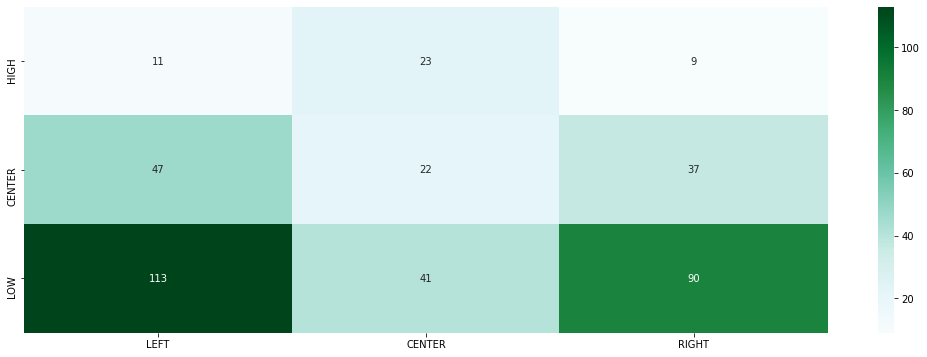

In [ ]:
gate = np.zeros((3,3))

gate[2][0] = pdPenalty.loc[1205]['goals']
gate[2][1] = pdPenalty.loc[1201]['goals']
gate[2][2] = pdPenalty.loc[1202]['goals']
gate[1][0] = pdPenalty.loc[1204]['goals']
gate[1][1] = pdPenalty.loc[1203]['goals']
gate[1][2] = pdPenalty.loc[1206]['goals']
gate[0][0] = pdPenalty.loc[1208]['goals']
gate[0][1] = pdPenalty.loc[1207]['goals']
gate[0][2] = pdPenalty.loc[1209]['goals']

fig, ax = plt.subplots(figsize=(18,6))
ax = sns.heatmap(gate, ax=ax, annot=True, fmt='g', cmap = 'BuGn',xticklabels=['LEFT','CENTER','RIGHT'], yticklabels=['HIGH','CENTER','LOW'])
fig.show()

## 4. Czy opłaca się wymieniać napastników - kryterium goli

In [ ]:
# gole pierwszego zespołu
lg = matches.select(matches.wyId,matches.info.formation.lineup.goals.alias("lineupGoals"))\
    .withColumn("lineupGoals",f.explode(f.col("lineupGoals")))\
    .withColumn("lineupGoals",f.col("lineupGoals").cast(IntegerType()))\
    .fillna(0,subset=("lineupGoals"))\
    .groupBy(matches.wyId)\
    .agg(f.sum("lineupGoals").alias("lineupGoals"))

# gole rezerwowych
bg = matches.select(matches.wyId,matches.info.formation.bench.goals.alias("benchGoals"))\
    .withColumn("benchGoals",f.explode(f.col("benchGoals")))\
    .withColumn("benchGoals",f.col("benchGoals").cast(IntegerType()))\
    .fillna(0,subset=("benchGoals"))\
    .groupBy(matches.wyId)\
    .agg(f.sum("benchGoals").alias("benchGoals"))

# średnia minuta dokonywania zmian
subTime = matches.select(matches.wyId,matches.info.formation.substitutions.minute.alias("minute"))\
    .withColumn("minute",f.explode(f.col("minute")))\
    .agg(f.round(f.avg("minute"),0).alias("avg_minute"))

avgTimeSub = subTime.first()[0]

g = lg.join(bg, on="wyId").agg(f.sum("lineupGoals").alias("lineupGoals"),f.sum("benchGoals").alias("benchGoals"))

g.show(1000,truncate=False)

+-----------+----------+
|lineupGoals|benchGoals|
+-----------+----------+
|4281       |513       |
+-----------+----------+



In [ ]:
# średnia minuta dokonywania zmian.
avgTimeSub

70.0

In [ ]:
# pozycja zawodników
playerRole = players.select(f.col("wyId").alias("playerId"),f.col("role.code2").alias("role"))

playerGoals = matches\
    .select("wyId","team",f.col("info.formation.lineup.playerId").alias("playerId"),f.col("info.formation.lineup.goals").alias("goal"))

playerGoals = playerGoals.withColumn("zip",f.arrays_zip(f.col("playerId"),f.col("goal")))\
    .withColumn("zip",f.explode(f.col("zip")))\
    .select("wyId","team","zip")

playerGoals = playerGoals.select("wyId","team","zip.*")\
    .withColumn("goal", f.col("goal").cast(IntegerType()))\
    .dropna()\
    .filter(f.col("goal") != 0)\
    .orderBy(f.col("goal").desc())

pdPlayerGoals = playerGoals\
    .join(playerRole,on="playerId")\
    .select("role","goal")\
    .groupBy("role")\
    .agg(f.sum("goal").alias("goal"))\
    .orderBy(f.col("goal").desc())\
    .toPandas()

pdPlayerGoals.set_index("role")

labels = pdPlayerGoals["role"]
values = pdPlayerGoals["goal"]
pdPlayerGoals

,role,goal
0,FW,2363
1,MD,1394
2,DF,523
3,GK,1


In [ ]:
fig = go.Figure(data=[go.Pie(labels=labels, values=values, textinfo='label+percent+value')])
fig.show()


In [ ]:
ev = events\
    .filter((f.array_contains(f.expr("tags.id"), 101)) & (f.col("eventName") != 'Save attempt') & (f.col("matchPeriod") == '2H'))\
    .select("eventSec","playerId","eventName",f.expr("tags.id").alias("tagId"),"teamId","matchPeriod","matchId")\
    .withColumn("eventMin",f.floor(f.col("eventSec")/60)+45)\
    .groupBy("teamId", "playerId","eventMin","matchId")\
    .agg(f.count("teamId").alias("goal"))\
    .orderBy(f.col("goal").desc())

m = matches.select(f.col("wyId").alias("matchId"),"team",f.col("info.formation.lineup.playerId").alias("lineupPlayerId"),f.col("info.formation.bench.playerId").alias("benchPlayerId"))\

pdJokers = ev.filter(f.col("eventMin") >= avgTimeSub)\
    .join(playerRole, on="playerId")\
    .join(m, (ev.matchId == m.matchId) & (ev.teamId == m.team))\
    .withColumn("lineupGoal", f.when(f.array_contains(f.col("lineupPlayerId"),f.col("playerId")),1).otherwise(0))\
    .withColumn("benchGoal", f.when(f.array_contains(f.col("benchPlayerId"),f.col("playerId")),1).otherwise(0))\
    .groupBy("role")\
    .agg(f.sum("lineupGoal").alias("lineupGoal"),f.sum("benchGoal").alias("benchGoal"))\
    .toPandas()
pdJokers

,role,lineupGoal,benchGoal
0,FW,510,273
1,MD,312,126
2,GK,1,0
3,DF,140,14


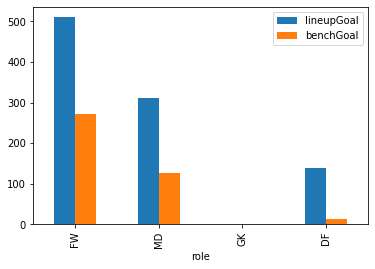

In [ ]:
# porównanie goli strzelonych przez rezerwowych do goli strzelonych przez podstawowy skład po średniej minucie dokonywania zmian
pdJokers.set_index("role").plot(kind='bar')
pass

## 5. Prezentacja przestrzenna zdarzeń

In [ ]:
# rysowanie boiska
def pitch():
    
    #create figure
    fig,ax=plt.subplots(figsize=(7,5))
    
    #Pitch Outline & Centre Line
    plt.plot([0,0],[0,100], color="black")
    plt.plot([0,100],[100,100], color="black")
    plt.plot([100,100],[100,0], color="black")
    plt.plot([100,0],[0,0], color="black")
    plt.plot([50,50],[0,100], color="black")

    #Left Penalty Area
    plt.plot([16.5,16.5],[80,20],color="black")
    plt.plot([0,16.5],[80,80],color="black")
    plt.plot([16.5,0],[20,20],color="black")

    #Right Penalty Area
    plt.plot([83.5,100],[80,80],color="black")
    plt.plot([83.5,83.5],[80,20],color="black")
    plt.plot([83.5,100],[20,20],color="black")

    #Left 6-yard Box
    plt.plot([0,5.5],[65,65],color="black")
    plt.plot([5.5,5.5],[65,35],color="black")
    plt.plot([5.5,0.5],[35,35],color="black")

    #Right 6-yard Box
    plt.plot([100,94.5],[65,65],color="black")
    plt.plot([94.5,94.5],[65,35],color="black")
    plt.plot([94.5,100],[35,35],color="black")

    #Prepare Circles
    centreCircle = Ellipse((50, 50), width=30, height=39, edgecolor="black", facecolor="None", lw=1.8)
    centreSpot = Ellipse((50, 50), width=1, height=1.5, edgecolor="black", facecolor="black", lw=1.8)
    leftPenSpot = Ellipse((11, 50), width=1, height=1.5, edgecolor="black", facecolor="black", lw=1.8)
    rightPenSpot = Ellipse((89, 50), width=1, height=1.5, edgecolor="black", facecolor="black", lw=1.8)

    #Draw Circles
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)
    ax.add_patch(leftPenSpot)
    ax.add_patch(rightPenSpot)
    
    #limit axis
    plt.xlim(0,100)
    plt.ylim(0,100)
    
    ax.annotate("", xy=(25, 5), xytext=(5, 5),
                arrowprops=dict(arrowstyle="->", linewidth=2))
    ax.text(7,7,'Attack',fontsize=20)
    return fig,ax

In [ ]:
matchId = 2576035
teamId = 3162
m = matches\
  .filter(f.col("wyId") == matchId)\
  .select("label","dateutc",f.col("info.teamId").alias("teamId"))

m.join(teams, teams.wyId == m.teamId, how='inner')\
  .select("label","dateutc","name","teamId")\
  .show(truncate=False)

+-----------------------+-------------------+--------+------+
|label                  |dateutc            |name    |teamId|
+-----------------------+-------------------+--------+------+
|Juventus - Lazio, 1 - 2|2017-10-14 16:00:00|Juventus|3159  |
|Juventus - Lazio, 1 - 2|2017-10-14 16:00:00|Lazio   |3162  |
+-----------------------+-------------------+--------+------+



In [ ]:
# podania, dryblingi, strzały
eventType = ["Pass", "Duel", "Shot"]
ev = events\
    .filter(f.col("matchId") == matchId)\
    .filter(f.col("eventName").isin(list(eventType)))\
    .filter(f.col("teamId") == teamId)\
    .select("matchId","teamId","eventName",f.expr("positions[0]").alias("position1"))\
    .withColumn("x", f.col("position1").getField("x"))\
    .withColumn("y", f.col("position1").getField("y"))

# .filter(f.col("eventName").isin(list(eventType)))\ # Inter - Lazio 3-2 
# .filter(f.col("playerId") == 21384)\ # 265865 - Milinkovic-Savic,  21384 - Immobile 

df = ev.select("eventName", "x", "y")\
    .toPandas()


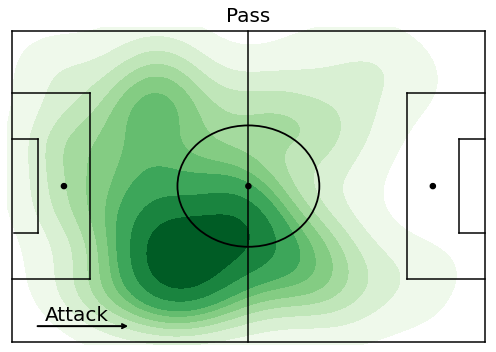

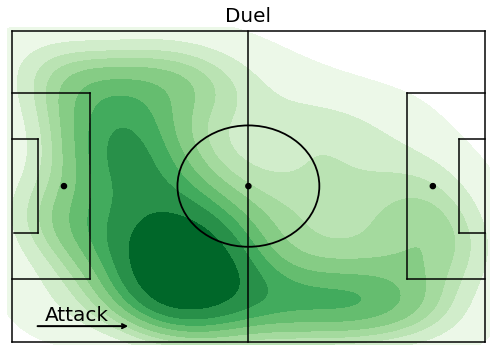

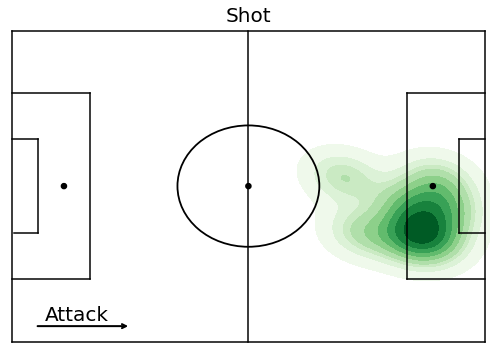

In [ ]:
for event_type in eventType:
  pos_event_df = df[df['eventName'] == event_type]
  fig, ax = pitch()    
  if len(pos_event_df) > 2:
      sns.kdeplot(data=pos_event_df, x="x", y="y", cmap = 'Greens', shade = True)
      # sns.scatterplot(data=pos_event_df, x="x", y="y")
  else:
      sns.scatterplot(data=pos_event_df, x="x", y="y")

  plt.title(event_type, fontsize = 20)
  plt.xlim(-1,101)
  plt.ylim(-1,101)
  plt.axis('off')
  fig.tight_layout()
  plt.show()

# **Predykcja wyników meczy**

Model składa się z trzech faz:
1. Wyliczenie wag poszczególnych zdarzeń w meczu prowadzących do ogólnej oceny danego zespołu. Każda cecha liczona jest jako różnica pomiędzy drużynami. Zatem pojedynczy mecz będzie przedstawiony w dwóch rekordach, po jednym dla każdej drużyny. Szukamy etykiety strzelonych goli.  
$$
y = \cases{ 1 \,- \,goalscored > 0\\ 
            0 \,- \,goalscored <= 0}
$$

2. Wyliczenie oceny poszczególnych zawodników w danym meczu na podstawie ilości zagrań i wagi danego zagrania wyliczonej w punkcie 1. Następnie agregujemy sumując poszczególną ocenę zawodnika do formacji, w której zawodnik występuje.  
3. Przygotowanie nowych cech. Jedna próbka będzie zawierała wartości poszczególnych formacji dla drużyny grającej u siebie i na wyjeździe. Etykietą przedstawia rezultat
$$
y = \cases{ 1 \,- \,home\,team\,win\\ 
            0 \,- \,draw\\
            2\,- \,away\,team\,win\\}
$$


## Funkcje ##

In [ ]:
# def run_model_diagnostics(X, y, clfs, size = .2, state = 42, is_classification = True, get_metrics = True):
def run_model_diagnostics(X_train, X_test, y_train, y_test, clfs, is_classification = True, get_metrics = True):
    
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = size, random_state = state)

    if get_metrics:
        metric_map = { str(type(clf)).split('.')[-1][:-2]: [] for clf in clfs }

    for clf in clfs:
        clf_name = str(type(clf)).split('.')[-1][:-2]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        if is_classification:
          # score
            metric_map[clf_name].append( clf.score(X_test, y_test) )
        else:
          # rmse
            metric_map[clf_name].append( mean_squared_error(y_test, y_pred) ** .5)
    if get_metrics:
        return metric_map
    else:
        return (y_test, y_pred, clfs)

## Selekcja cech i ocena wag ##

In [ ]:
# rejected goalkeeper position
fieldPlayer = players.filter(f.col("role.code2") != 'GK')

# assign team's side
side = matches.select("dateutc", "gameweek", "wyId", "team", "info.side", "competitionId")

# tag's description
tagsName={
101: "goal",
102: "own_goal",
301: "assist",
302:	"keyPass",
1901:	"counter_attack",
401:	"left_foot",
402:	"right_foot",
403:	"head/body",
1101:	"direct",
1102:	"indirect",
2001:	"dangerous_ball_lost",
2101:	"blocked",
801:	"high",
802:	"low",
1401:	"interception",
1501:	"clearance",
201:	"opportunity",
1301:	"feint",
1302:	"missed_ball",
501:	"free_space_r",
502:	"free_space_l",
503:	"take_on_l",
504:	"take_on_r",
1601:	"sliding_tackle",
601:	"anticipated",
602:	"anticipation",
1701:	"red_card",
1702:	"yellow_card",
1703:	"second_yellow_card",
1201:	"goal_low_center",
1202:	"goal_low_right",
1203:	"goal_center",
1204:	"goal_center_left",
1205:	"goal_low_left",
1206:	"goal_center_right",
1207:	"goal_high_center",
1208:	"goal_high_left",
1209:	"goal_high_right",
1210:	"out_low_right",
1211:	"out_center_left",
1212:	"out_low_left",
1213:	"out_center_right",
1214:	"out_high_center",
1215:	"out_high_left",
1216:	"out_high_right",
1217:	"post_low_right",
1218:	"post_center_left",
1219:	"post_low_left",
1220:	"post_center_right",
1221:	"post_high_center",
1222:	"post_high_left",
1223:	"post_high_right",
901:	"through",
1001:	"fairplay",
701:	"lost",
702:	"neutral",
703:	"won",
1801:	"accurate",
1802:	"not_accurate"}

# selecting an event and specific tags intuitively
qualityFeature = {
                  "Air duel": [1801, 1802],
                  "Ground attacking duel": [1801, 1802],
                  "Ground defending duel": [1801, 1802],
                  "Ground loose ball duel": [1801, 1802],
                  "Foul": [1702, 1703, 1701],
                  "Hand foul": [1702, 1703, 1701],
                  "Late card foul": [1702, 1703, 1701],
                  "Out of game foul": [1702, 1703, 1701],
                  "Protest": [1702, 1703, 1701],
                  "Simulation": [1702, 1703, 1701],
                  "Time lost foul": [1702, 1703, 1701],
                  "Violent Foul": [1702, 1703, 1701],
                  "Corner": [101, 1801, 1802],
                  "Free Kick": [101, 1801, 1802],
                  "Free kick cross": [1801, 1802],
                  "Free kick shot": [1801, 1802],
                  "Goal kick": [1801, 1802],
                  "Penalty": [101, 1802],
                  "Throw in": [1801, 1802],
                  "Goalkeeper leaving line": [1801, 1802],
                  "Offside": [],
                  "Acceleration": [1801, 1802, 101],
                  "Clearance": [1801, 1802, 101],
                  "Touch": [1401, 1302, 201, 1901, 1301, 2001, 301],
                  "Cross": [1801, 1802, 302, 301],
                  "Hand pass": [1801, 1802, 302, 301],
                  "Head pass": [1801, 1802, 302, 301],
                  "High pass": [1801, 1802, 302, 301],
                  "Launch": [1801, 1802, 302, 301],
                  "Simple pass": [1801, 1802, 302, 301],
                  "Smart pass": [1801, 1802, 302, 301],
                  "Shot": [101, 1801, 1802]}
qualityFeature = spark.createDataFrame([(tup[0], tup[1]) for tup in qualityFeature.items()], ["subEvName", "tagsId"])
# qualityFeature.show(100, truncate=False)

mapping_expr = f.create_map([f.lit(x) for x in chain(*tagsName.items())])

In [ ]:
# features extraction

quality1 = events\
  .filter(f.col("eventId") != 9)\
  .join(side, (events.matchId == side.wyId) & (events.teamId == side.team), how='inner')\
  .select("competitionId", "dateutc","gameweek", "eventId","matchId", "side", "subEventName", f.explode("tags.id").alias("tagId"))\
  .join(qualityFeature, (f.col("subEventName") == qualityFeature.subEvName) & f.array_contains(qualityFeature.tagsId, f.col("tagId")), how='inner')\
  .withColumn("tagName", mapping_expr[f.col("tagId")])\
  .select("competitionId", "dateutc","gameweek", "eventId", "matchId", "side", f.concat("subEventName",f.lit("-"),"tagName").alias("feature"),"tagId")\
  .withColumn("feature", f.when(f.col("eventId") == 2, "Foul")\
            .when(f.col("tagId") == 101, "Goal scored")
            .otherwise(f.col("feature")))\
  .groupBy("competitionId", "dateutc","gameweek", "matchId","feature","side")\
  .agg(f.count("feature").alias("value"))\
  .withColumn("value",f.when(f.col("side") == 'away',-1*f.col("value")).otherwise(f.col("value")))\
  .groupby("competitionId","dateutc","gameweek","matchId","feature")\
  .agg(f.sum("value").alias("value"))

# quality1.show(200, truncate=False)

quality2 = quality1.withColumn("value",-1*f.col("value"))

quality1 = quality1.groupBy("competitionId", "dateutc","gameweek","matchId").pivot("feature").agg(f.first("value").alias("value")).fillna(0)
quality2 = quality2.groupBy("competitionId", "dateutc","gameweek","matchId").pivot("feature").agg(f.first("value").alias("value")).fillna(0)

quality = quality1.union(quality2).orderBy("matchId").drop("matchId")

qualityPD = quality.toPandas()
qualityPD

,competitionId,dateutc,gameweek,Acceleration-accurate,Acceleration-not_accurate,Air duel-accurate,Air duel-not_accurate,Clearance-accurate,Clearance-not_accurate,Corner-accurate,Corner-not_accurate,Cross-accurate,Cross-assist,Cross-keyPass,Cross-not_accurate,Foul,Free Kick-accurate,Free Kick-not_accurate,Free kick cross-accurate,Free kick cross-not_accurate,Free kick shot-accurate,Free kick shot-not_accurate,Goal scored,Ground attacking duel-accurate,Ground attacking duel-not_accurate,Ground defending duel-accurate,Ground defending duel-not_accurate,Ground loose ball duel-accurate,Ground loose ball duel-not_accurate,Hand pass-accurate,Hand pass-keyPass,Hand pass-not_accurate,Head pass-accurate,Head pass-assist,Head pass-keyPass,Head pass-not_accurate,High pass-accurate,High pass-assist,High pass-keyPass,High pass-not_accurate,Launch-accurate,Launch-keyPass,Launch-not_accurate,Penalty-not_accurate,Shot-accurate,Shot-not_accurate,Simple pass-accurate,Simple pass-assist,Simple pass-keyPass,Simple pass-not_accurate,Smart pass-accurate,Smart pass-assist,Smart pass-keyPass,Smart pass-not_accurate,Throw in-accurate,Throw in-not_accurate,Touch-assist,Touch-counter_attack,Touch-dangerous_ball_lost,Touch-feint,Touch-interception,Touch-missed_ball,Touch-opportunity
0,364,2017-08-11 18:45:00,1,6,0,-6,6,-1,-1,3,2,0,0,1,2,-1,3,-2,-2,0,0,0,1,23,-6,6,-23,9,-9,1,0,0,1,-1,0,-1,6,0,0,2,-5,0,-3,0,6,14,344,2,1,34,0,0,1,-5,-9,-1,0,-2,0,0,-11,-2,0
1,364,2017-08-11 18:45:00,1,-6,0,6,-6,1,1,-3,-2,0,0,-1,-2,1,-3,2,2,0,0,0,-1,-23,6,-6,23,-9,9,-1,0,0,-1,1,0,1,-6,0,0,-2,5,0,3,0,-6,-14,-344,-2,-1,-34,0,0,-1,5,9,1,0,2,0,0,11,2,0
2,364,2017-08-12 16:30:00,1,-9,1,-10,10,8,13,-7,0,-6,0,0,-13,-2,-3,1,1,1,-1,-1,-1,-9,-8,8,9,-2,2,-4,0,0,-5,0,0,-1,-10,0,-1,6,4,0,6,0,-1,-5,-529,0,0,-3,-8,-1,-1,-7,-1,2,0,-1,1,-1,11,-5,-5
3,364,2017-08-12 16:30:00,1,9,-1,10,-10,-8,-13,7,0,6,0,0,13,2,3,-1,-1,-1,1,1,1,9,8,-8,-9,2,-2,4,0,0,5,0,0,1,10,0,1,-6,-4,0,-6,0,1,5,529,0,0,3,8,1,1,7,1,-2,0,1,-1,1,-11,5,5
4,364,2017-08-12 14:00:00,1,0,1,-7,7,-3,-12,4,-1,6,-1,0,11,3,-4,-2,0,0,1,-1,-1,22,-1,-8,-13,-5,5,2,0,0,-3,1,0,1,14,0,1,6,1,0,-2,0,0,6,186,0,0,-4,3,-1,0,-1,6,0,0,0,0,0,-9,-3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3647,524,2018-05-20 18:45:00,38,-4,0,4,-4,-5,2,2,2,0,0,1,8,0,1,0,1,2,0,0,0,21,2,-8,-15,5,-5,1,0,-1,3,0,0,0,-1,0,0,-4,0,0,2,0,3,-2,157,0,0,-5,1,0,-1,2,-6,-4,0,-1,0,1,-1,1,0
3648,524,2018-05-20 16:00:00,38,4,0,4,-4,4,7,3,-1,2,1,0,-8,-3,-4,1,-1,-1,0,0,2,-23,-2,7,18,-1,1,0,0,0,-6,-1,0,-1,-5,1,1,3,6,0,7,0,2,3,-66,0,0,-9,-2,0,0,-4,-1,-1,0,0,0,0,6,-1,0
3649,524,2018-05-20 16:00:00,38,-4,0,-4,4,-4,-7,-3,1,-2,-1,0,8,3,4,-1,1,1,0,0,-2,23,2,-7,-18,1,-1,0,0,0,6,1,0,1,5,-1,-1,-3,-6,0,-7,0,-2,-3,66,0,0,9,2,0,0,4,1,1,0,0,0,0,-6,1,0
3650,524,2018-05-20 13:00:00,38,-5,0,-10,10,-4,-7,1,3,2,-2,1,5,-2,-3,0,1,1,0,2,-1,21,-2,1,-20,2,-2,0,0,0,7,0,0,1,2,0,0,-1,2,0,-2,0,0,7,159,0,0,13,2,0,2,4,17,1,0,1,0,1,-6,-12,1


## Biblioteki ML##

In [ ]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC

## Budowa modelu ##

In [ ]:
# preparation of the list of features. To remove unnecessary column, target and features that result from it, i.e. assists
to_drop = [col for col in qualityPD.columns if col.endswith('assist')]
to_drop.extend(["gameweek","dateutc","competitionId"])
to_drop

['Cross-assist',
 'Head pass-assist',
 'High pass-assist',
 'Simple pass-assist',
 'Smart pass-assist',
 'Touch-assist',
 'gameweek',
 'dateutc',
 'competitionId']

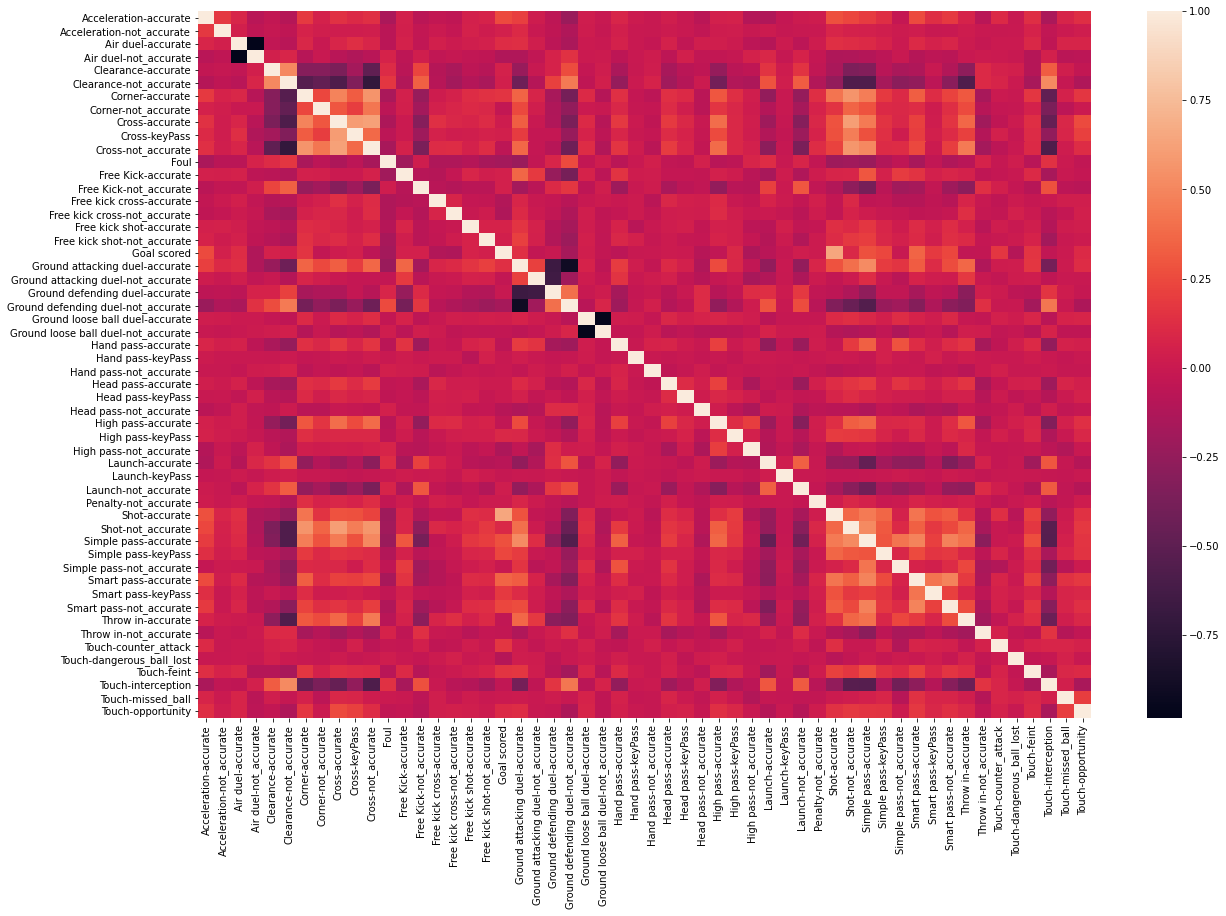

In [ ]:
fig, ax = plt.subplots(figsize=(20,13))
corr = qualityPD.drop(to_drop, axis=1).corr()
ax = sns.heatmap(corr)
fig.show()

## 1 Wyliczenie wag poszczególnych zagrań w meczu##

### Przygotowanie danych testowych i treningowych ###
Zbiór treningowy będzie zawierał dane do 30 kolejki w danej lidze. Zbiór testowy pozostałe. Ilość kolejek w lidze niemieckiej wynosi 34, w pozostałych ligach jest ich 38. Zatem stosunek zbióru testowego będzie wynosił ok. 0.2 




In [ ]:
to_drop.insert(0, "Goal scored")
feature_names =  qualityPD.drop(to_drop, axis=1).columns

X_train = qualityPD[qualityPD.gameweek<31].drop(to_drop, axis=1).values
X_test = qualityPD[qualityPD.gameweek>30].drop(to_drop, axis=1).values

y_train = qualityPD.loc[qualityPD.gameweek<31,"Goal scored"].apply(lambda x: 1 if x > 0 else 0)
y_test = qualityPD.loc[qualityPD.gameweek>30,"Goal scored"].apply(lambda x: 1 if x > 0 else 0)

# X_train = StandardScaler().fit_transform(X_train)
# X_test = StandardScaler().fit_transform(X_test)

### Modelowanie ###

In [ ]:
clfs = [LogisticRegression(), LinearSVC()]

# run_model_diagnostics(X, y, clfs)
oneMetricMap = run_model_diagnostics(X_train, X_test, y_train, y_test, clfs)

df = pd.DataFrame(oneMetricMap).T
df.reset_index(inplace=True)
df.columns = ["model","score"]
df.score = np.round(df.score,3)
px.bar(data_frame=df, x="model", y="score", text="score")

In [ ]:
clf = LogisticRegression(max_iter=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# reports
X = np.concatenate((X_train ,X_test), axis=0)
y = np.concatenate((y_train ,y_test), axis=0)
f1_score = np.mean(cross_val_score(clf, X, y, cv=2, scoring='f1_weighted'))
print("f1: %.3f \t accuracy: %.3f" % (f1_score, clf.score(X_test, y_test)))
print(metrics.classification_report(y_test, y_pred, digits=3))
print(metrics.confusion_matrix(y_test, y_pred))


f1: 0.771 	 accuracy: 0.781
              precision    recall  f1-score   support

           0      0.825     0.829     0.827       449
           1      0.705     0.700     0.702       263

    accuracy                          0.781       712
   macro avg      0.765     0.764     0.764       712
weighted avg      0.781     0.781     0.781       712

[[372  77]
 [ 79 184]]


In [ ]:
# feature
importances = clf.coef_[0]
indices = np.argsort(importances)[::-1]
indices

for fn in range(X_train.shape[1]):
    print(f"{fn+1:2d}. {feature_names[indices[fn]]:35} \t {importances[indices[fn]]}")

 1. Shot-accurate                       	 0.43280732164822366
 2. Free Kick-not_accurate              	 0.12184826021535711
 3. Hand pass-not_accurate              	 0.08495286173484068
 4. Touch-counter_attack                	 0.07871306009214328
 5. Penalty-not_accurate                	 0.06726114813474733
 6. Smart pass-accurate                 	 0.05949719457225359
 7. Throw in-not_accurate               	 0.047564930684902675
 8. Clearance-not_accurate              	 0.04487301538271767
 9. Acceleration-accurate               	 0.04317269778277671
10. Clearance-accurate                  	 0.042817212411880974
11. Touch-opportunity                   	 0.037684797306057304
12. Corner-accurate                     	 0.03480840336715656
13. Launch-accurate                     	 0.03435065427074625
14. Ground loose ball duel-not_accurate 	 0.022571546754441403
15. Launch-not_accurate                 	 0.021849453488525912
16. Ground defending duel-not_accurate  	 0.016581260033064267
17

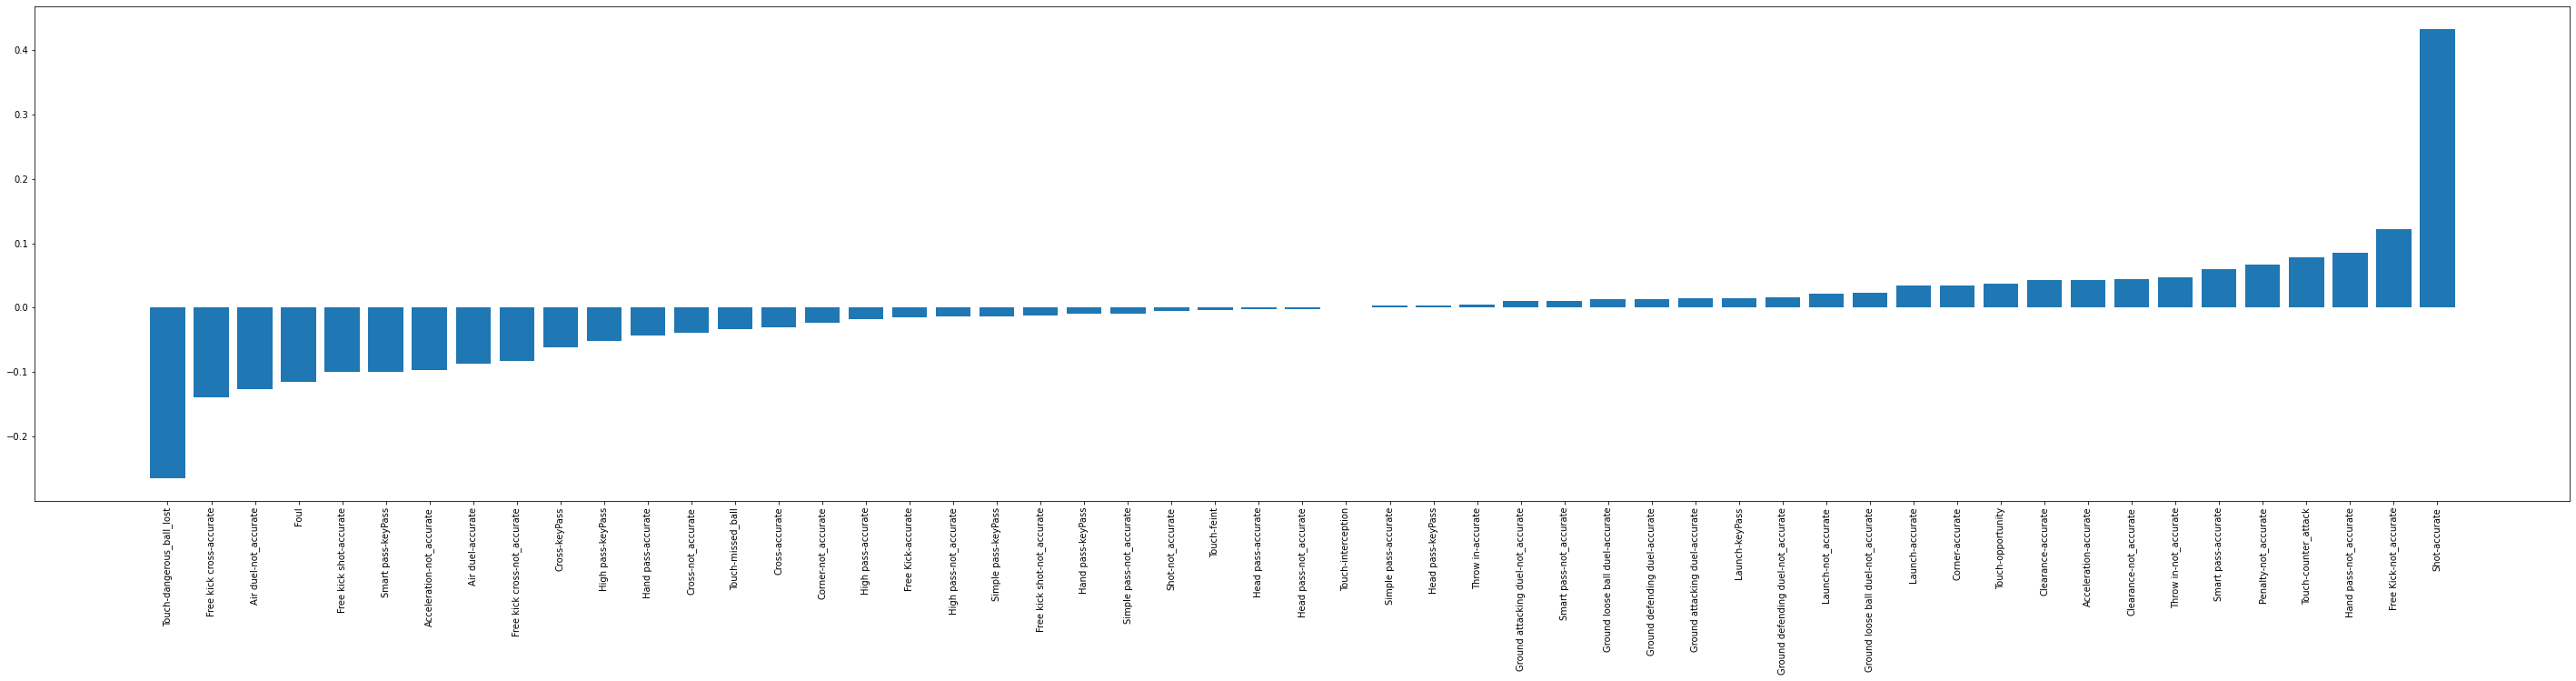

In [ ]:
# sum_importances = sum(np.abs(importances[indices]))
# weights = importances / sum_importances

features_and_weights = {}
for feature, weight in sorted(zip(feature_names[indices], importances[indices]),key = lambda x: x[1]):
  features_and_weights[feature] = weight

pdCoef = pd.Series(features_and_weights)
pdCoef.sort_values(inplace=True)

fig, axs = plt.subplots(figsize=(50,10))
axs.bar(x=pdCoef.index,height=pdCoef)
plt.xticks(rotation=90)
fig.show()

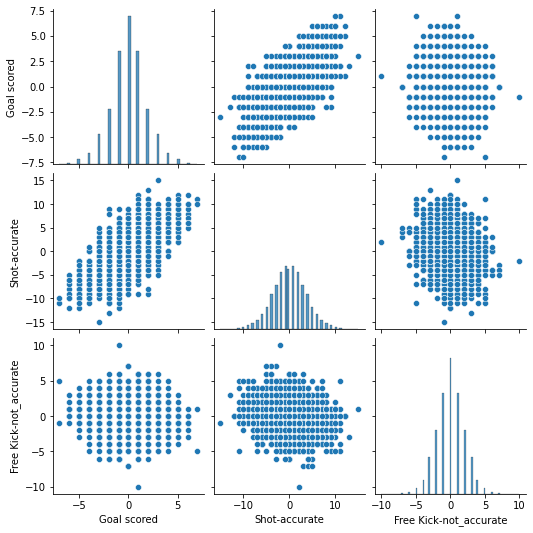

In [ ]:
_ = sns.pairplot(data=qualityPD[["Goal scored","Shot-accurate","Free Kick-not_accurate"]])

In [ ]:
# Spark's DataFrame for further processing
featuresWeight = spark.createDataFrame([(tup[0], float(tup[1])) for tup in features_and_weights.items()], ["feature", "weight"])
featuresWeight.show(100, truncate=False)

+-----------------------------------+----------------------+
|feature                            |weight                |
+-----------------------------------+----------------------+
|Touch-dangerous_ball_lost          |-0.26496079958934154  |
|Free kick cross-accurate           |-0.13957012815179887  |
|Air duel-not_accurate              |-0.12679092643339912  |
|Foul                               |-0.11550436283960397  |
|Free kick shot-accurate            |-0.09957217294294507  |
|Smart pass-keyPass                 |-0.09943291053869259  |
|Acceleration-not_accurate          |-0.09683013041298005  |
|Air duel-accurate                  |-0.0869808589017288   |
|Free kick cross-not_accurate       |-0.08280403351937377  |
|Cross-keyPass                      |-0.0613608308032222   |
|High pass-keyPass                  |-0.05211396970572016  |
|Hand pass-accurate                 |-0.04359725234767723  |
|Cross-not_accurate                 |-0.03913680139327828  |
|Touch-missed_ball      

## 2 Ocena piłkarza ##

In [ ]:
# player rating - number of events with quantities. The goalkeeper position is rejected.
qualityPlayer = events\
    .filter(f.col("eventId") != 9)\
    .join(fieldPlayer, fieldPlayer.wyId == events.playerId, how='inner')\
    .select("eventId", "playerId", "matchId","subEventName", f.explode("tags.id").alias("tagId"))\
    .join(qualityFeature, (f.col("subEventName") == qualityFeature.subEvName) & f.array_contains(qualityFeature.tagsId, f.col("tagId")), how='inner')\
    .withColumn("tagName", mapping_expr[f.col("tagId")])\
    .select("eventId", "playerId", "matchId", f.concat("subEventName",f.lit("-"),"tagName").alias("feature"),"tagId")\
    .withColumn("feature", f.when(f.col("eventId") == 2, "Foul")\
            .when(f.col("tagId") == 101, "Goal scored")
            .otherwise(f.col("feature")))\
    .groupBy("matchId", "playerId", "feature")\
    .agg(f.count("feature").alias("value"))

# qualityPlayer.show(truncate=False)

playerankScore = qualityPlayer\
    .join(featuresWeight, on="feature")\
    .withColumn("playerankScore", f.col("value") * f.col("weight"))\
    .select("playerId","matchId","playerankScore")\
    .groupBy("playerId","matchId")\
    .agg(f.sum("playerankScore").alias("playerankScore"))
    
playerankScore.show(truncate=False)

+--------+-------+--------------------+
|playerId|matchId|playerankScore      |
+--------+-------+--------------------+
|228928  |2576084|0.019784995621797863|
|412701  |2500704|-0.3424673273787451 |
|265673  |2500065|0.7922233855861004  |
|15456   |2516973|-0.6749174351820777 |
|20820   |2576108|1.3351132101818157  |
|3802    |2499913|0.15304909579866943 |
|4498    |2565598|0.10748860406036012 |
|14836   |2565686|-0.1592784616756716 |
|105333  |2499855|0.7246682226968393  |
|25623   |2565744|0.06344742452680492 |
|3314    |2500898|-0.20411207293726288|
|256992  |2500867|-0.44697534667953204|
|209117  |2500793|0.2522944516564129  |
|14864   |2516990|0.1740823342444198  |
|20927   |2576318|0.17004626946947754 |
|28292   |2499917|-0.1938574383902421 |
|4303    |2565560|-0.3109610863799561 |
|143189  |2500821|0.12434936159800011 |
|342743  |2500875|0.012318121581773214|
|24838   |2576241|-0.14549600245970606|
+--------+-------+--------------------+
only showing top 20 rows



In [ ]:
# assigning to position
playerPosScore = playerankScore\
    .join(fieldPlayer.select(f.col("wyId").alias("playerId"),f.col("role.code2").alias("pos")), on="playerId", how="inner")\
    .groupBy("playerId", "matchId")\
    .pivot("pos")\
    .agg(f.first("playerankScore").alias("playerScore"))\
    .fillna(0)

playerPosScore.show()

+--------+-------+--------------------+-------------------+--------------------+
|playerId|matchId|                  DF|                 FW|                  MD|
+--------+-------+--------------------+-------------------+--------------------+
|  228928|2576084|                 0.0|                0.0|0.019784995621797863|
|  412701|2500704|                 0.0|-0.3424673273787451|                 0.0|
|  265673|2500065|                 0.0|                0.0|  0.7922233855861004|
|   15456|2516973|                 0.0|                0.0| -0.6749174351820777|
|   20820|2576108|                 0.0| 1.3351132101818157|                 0.0|
|    3802|2499913|                 0.0|0.15304909579866943|                 0.0|
|    4498|2565598|                 0.0|0.10748860406036012|                 0.0|
|   14836|2565686|                 0.0|                0.0| -0.1592784616756716|
|  105333|2499855|                 0.0|                0.0|  0.7246682226968393|
|   25623|2565744|          

In [ ]:
# aggratate to a single match
matchInfo = matches\
    .select("dateutc","gameweek", "competitionId", "info.side", f.col("wyId").alias("matchId"),"team","info.formation.lineup.playerId","info.formation.substitutions.playerIn","winner")\
    .withColumn("players",f.concat(f.col("playerId"),f.col("playerIn")))\
    .drop("playerId","playerIn")\
    .withColumn("playerId", f.explode("players"))\
    .drop("players")\

# home win -> 1, draw -> 0, away win -> 2
aggForPredict = matchInfo\
    .join(playerPosScore, (playerPosScore.matchId == matchInfo.matchId) & (playerPosScore.playerId == matchInfo.playerId), how='inner')\
    .groupBy("dateutc","gameweek","side","winner","team", matchInfo.matchId, "competitionId")\
    .agg(f.sum("DF").alias("dfScore"),f.sum("FW").alias("fwScore"),f.sum("MD").alias("mdScore"))\
    .groupBy("dateutc","gameweek","matchId", "competitionId")\
    .pivot("side")\
    .agg(f.first("winner").alias("winner"), f.first("team").alias("team"), f.first("dfScore").alias("dfScore"), f.first("fwScore").alias("fwScore"), f.first("mdScore").alias("mdScore"))\
    .withColumn("winner", f.when(f.col("home_winner") == 0, 0).when(f.col("home_winner") == f.col("home_team"),1).otherwise(2))\
    .drop("away_winner","home_winner","matchId")\
    .orderBy("competitionId","gameweek")\

# aggForPredict2.show(truncate=False)
pdAggForPredict = aggForPredict.toPandas()
pdAggForPredict


,dateutc,gameweek,competitionId,away_team,away_dfScore,away_fwScore,away_mdScore,home_team,home_dfScore,home_fwScore,home_mdScore,winner
0,2017-08-12 16:30:00,1,364,1625,-0.575403,0.500809,0.832219,1651,1.452734,-2.082286,-0.324194,2
1,2017-08-12 14:00:00,1,364,10531,-0.059684,-0.254909,-1.444849,1619,-0.976969,-0.305286,-0.135376,0
2,2017-08-13 15:00:00,1,364,1633,-0.070962,-2.141393,0.226555,1611,-0.331965,0.600707,0.502351,1
3,2017-08-13 12:30:00,1,364,1624,-0.603748,0.152692,2.921574,1613,-0.152546,-0.704952,0.073219,2
4,2017-08-11 18:45:00,1,364,1631,-1.137762,0.358511,0.411189,1609,0.295115,1.070532,1.801655,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1821,2018-05-20 16:30:00,38,795,701,-0.705474,-0.434375,1.131937,679,-0.892268,0.756037,0.052290,0
1822,2018-05-19 14:15:00,38,795,684,1.987180,1.906912,1.092720,712,0.583085,0.758319,0.418824,1
1823,2018-05-19 16:30:00,38,795,696,0.169883,-0.734881,0.417304,680,0.276292,0.940943,2.735210,1
1824,2018-05-19 18:45:00,38,795,675,0.790374,1.373215,1.855026,682,0.518552,0.670319,1.386667,0


## 3 Przewidywanie rezultatu ##

### Przygotowanie danych treningowych i testowych ###
Zbiór treningowy będzie zawierał dane do 30 kolejki w danej lidze. Zbiór testowy pozostałe. Ilość kolejek w lidze niemieckiej wynosi 34, w pozostałych ligach jest ich 38. Zatem stosunek zbióru testowego będzie wynosił ok. 0.2

In [ ]:
pdAggForPredict["away_team"] = pdAggForPredict["away_team"].astype('int64')
pdAggForPredict["home_team"] = pdAggForPredict["home_team"].astype('int64')
pdAggForPredict["competitionId"] = pdAggForPredict["competitionId"].astype('int64')

In [ ]:
# different style of leagues - for testing purposes, to determined if there is a style of the league. Test dataset for the German league, Train dataset for others
pdAggForPredict.sort_values(["gameweek", "competitionId"], inplace=True)
X = pdAggForPredict.drop(["winner","gameweek","away_team","home_team","dateutc"], axis=1)
y = pdAggForPredict[["winner","competitionId"]]

X_train = X[X["competitionId"]!=426].drop("competitionId", axis=1).values
X_test = X[X["competitionId"]==426].drop("competitionId", axis=1).values
y_train =  y[y["competitionId"]!=426].drop("competitionId", axis=1).values
y_test = y[y["competitionId"]==426].drop("competitionId", axis=1).values

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [ ]:
# all leagues
pdAggForPredict.sort_values(["gameweek", "competitionId"], inplace=True)

X_train = pdAggForPredict[pdAggForPredict.gameweek<31].drop(["winner","dateutc","competitionId","gameweek","away_team","home_team"], axis=1).values
X_test = pdAggForPredict[pdAggForPredict.gameweek>30].drop(["winner","dateutc","competitionId","gameweek","away_team","home_team"], axis=1).values
y_train =  pdAggForPredict.loc[pdAggForPredict.gameweek<31,"winner"].values
y_test =  pdAggForPredict.loc[pdAggForPredict.gameweek>30,"winner"].values

feature_names =  pdAggForPredict.drop(["winner","dateutc","competitionId","gameweek","away_team","home_team"], axis=1).columns

# X_train = StandardScaler().fit_transform(X_train)
# X_test = StandardScaler().fit_transform(X_test)

### Modelowanie ##

In [ ]:
clfs = [LogisticRegression(), RandomForestClassifier(), GradientBoostingClassifier(),
        KNeighborsClassifier(), GaussianNB(), MLPClassifier(), SVC(), LinearSVC()]

# run_model_diagnostics(X, y, clfs)
oneMetricMap = run_model_diagnostics(X_train, X_test, y_train, y_test, clfs)

df = pd.DataFrame(oneMetricMap).T
df.reset_index(inplace=True)
df.columns = ["model","score"]
df.score = np.round(df.score,3)
px.bar(data_frame=df, x="model", y="score", text="score")

In [ ]:
clf = LogisticRegression(random_state=42, max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# reports
X = np.concatenate((X_train ,X_test), axis=0)
y = np.concatenate((y_train ,y_test), axis=0)
f1_score = np.mean(cross_val_score(clf, X, y, cv=2, scoring='f1_weighted'))
print("f1: %.3f \t accuracy: %.3f" % (f1_score, clf.score(X_test, y_test)))
print(metrics.classification_report(y_test, y_pred, digits=3))
print(metrics.confusion_matrix(y_test, y_pred))


f1: 0.622 	 accuracy: 0.677
              precision    recall  f1-score   support

           0      0.524     0.265     0.352        83
           1      0.737     0.870     0.798       161
           2      0.637     0.705     0.669       112

    accuracy                          0.677       356
   macro avg      0.633     0.613     0.606       356
weighted avg      0.656     0.677     0.653       356

[[ 22  31  30]
 [  6 140  15]
 [ 14  19  79]]


In [ ]:
# feature
importances = clf.coef_[0]
indices = np.argsort(importances)[::-1]
indices

for fn in range(X_train.shape[1]):
    print(f"{fn+1:2d}. {feature_names[indices[fn]]:35} \t {importances[indices[fn]]}")

 1. away_dfScore                        	 0.07505188796678204
 2. home_dfScore                        	 0.005796802245918418
 3. home_fwScore                        	 -0.09460403106995424
 4. home_mdScore                        	 -0.0971877120717761
 5. away_mdScore                        	 -0.10027170196373796
 6. away_fwScore                        	 -0.12023551227873347


## Sprawdzenie jednego meczu ## 

Póki co ocena formacji na podstawie średniej. Docelowo można spóbować ją przewidzieć algorytmami regresji liniowej

In [ ]:
# Barcelona (676) vs Real (675)
# Lazio (3162) vs Roma (3158)

team_home = pdAggForPredict.loc[pdAggForPredict["home_team"] == 676  , ["gameweek","home_dfScore","home_fwScore","home_mdScore"]]
team_away = pdAggForPredict.loc[pdAggForPredict["away_team"] == 675, ["gameweek","away_dfScore","away_fwScore","away_mdScore"]]

h_df = team_home["home_dfScore"].mean()
h_fw = team_home["home_fwScore"].mean()
h_md = team_home["home_mdScore"].mean()

a_df = team_away["away_dfScore"].mean()
a_fw = team_away["away_fwScore"].mean()
a_md = team_away["away_mdScore"].mean()

test = np.array([a_df,a_fw,a_md,h_df,h_fw,h_md])
print(test)
clf.predict(test.reshape(1,-1))


[0.04555269 1.19587743 1.44590986 0.79762139 2.68157136 0.87598644]


array([1], dtype=int32)

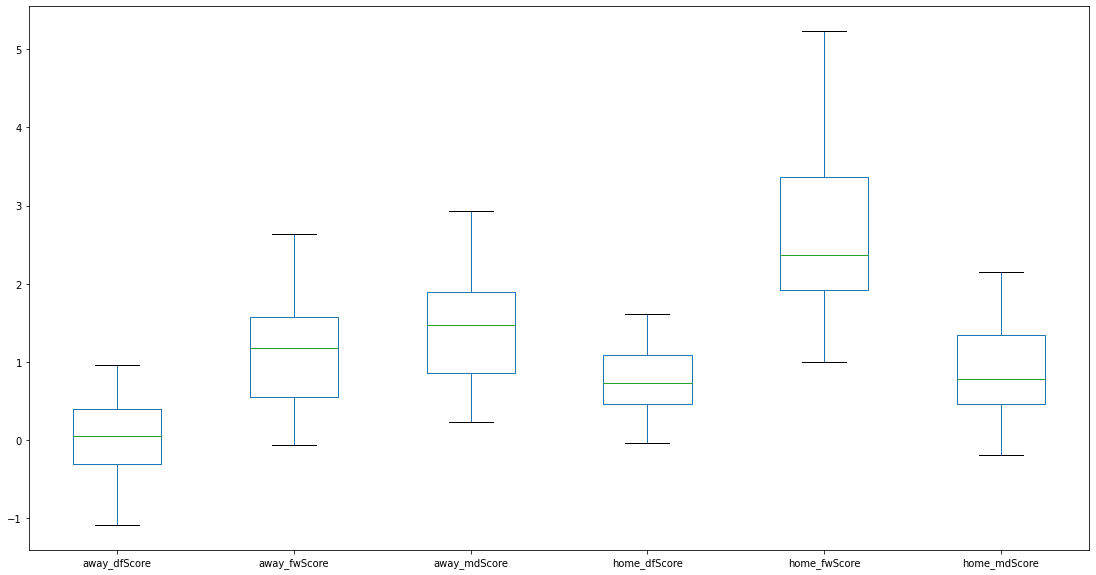

In [ ]:
team_home.set_index("gameweek", inplace=True)
team_away.set_index("gameweek", inplace=True)
team_home.reset_index(inplace=True)
team_away.reset_index(inplace=True)

hoaw = pd.concat([team_away, team_home], axis=1)
hoaw = hoaw[["away_dfScore","away_fwScore","away_mdScore","home_dfScore","home_fwScore","home_mdScore"]]
hoaw.plot(kind='box', figsize=(19,10))
pass

In [ ]:
teams.filter(f.col("area.name")=='Italy').select("name", "wyId").orderBy(f.col("name")).show(2000,False)
# teams.printSchema()

+--------------+----+
|name          |wyId|
+--------------+----+
|Atalanta      |3172|
|Benevento     |3219|
|Bologna       |3166|
|Cagliari      |3173|
|Chievo        |3165|
|Crotone       |3197|
|Fiorentina    |3176|
|Genoa         |3193|
|Hellas Verona |3194|
|Internazionale|3161|
|Italy         |3757|
|Juventus      |3159|
|Lazio         |3162|
|Milan         |3157|
|Napoli        |3187|
|Roma          |3158|
|SPAL          |3204|
|Sampdoria     |3164|
|Sassuolo      |3315|
|Torino        |3185|
|Udinese       |3163|
+--------------+----+

